In [29]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
# Create a function to process data, train model, and save it
def process_and_train_model(industry, stock_symbol, data_folder, model_folder, window_size=60, epochs=50, batch_size=32):
    # Create paths
    file_path = os.path.join(data_folder, industry, f"{stock_symbol}.csv")
    model_path = os.path.join(model_folder, industry, f"{stock_symbol}_model.keras")

    # Load and preprocess the data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    processed_data = pd.DataFrame(scaled_data, columns=['Close'])

    # Split into training and testing sets
    train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

    # Prepare training and testing data with sliding windows
    x_train, y_train = [], []
    x_test, y_test = [], []

    for i in range(window_size, len(train_data)):
        x_train.append(train_data[i - window_size:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  # Reshape for LSTM

    for i in range(window_size, len(test_data)):
        x_test.append(test_data[i - window_size:i, 0])
        y_test.append(test_data[i, 0])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape for LSTM

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_path, monitor='loss', save_best_only=True)
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop, model_checkpoint], validation_split=0.2)

    # Save the scaler for inverse transformations later
    scaler_path = os.path.join(model_folder, industry, f"{stock_symbol}_scaler.pkl")
    with open(scaler_path, 'wb') as f:
        import pickle
        pickle.dump(scaler, f)

    print(f"Model and scaler for {stock_symbol} saved in {model_folder}/{industry}")

# Create directories for models if they don't exist
def ensure_directories(model_folder, industries):
    for industry in industries:
        path = os.path.join(model_folder, industry)
        os.makedirs(path, exist_ok=True)

# Define industries and stocks
industries = {
    'agro': ['CBG.BK', 'OSP.BK', 'OKJ.BK', 'CPF.BK', 'TU.BK'],
    'consump': ['SNPS.BK', 'AURA.BK', 'SABINA.BK', 'STGT.BK', 'TMAN.BK'],
    'fincial': ['KBANK.BK', 'KTB.BK', 'SCB.BK', 'BBL.BK', 'TTB.BK'],
    'indus': ['IVL.BK', 'PTTGC.BK', 'SCGP.BK', 'RSXYZ.BK', 'TPCS.BK'],
    'propcon': ['AMATA.BK', 'CPN.BK', 'WHA.BK', 'SIRI.BK', 'SCC.BK'],
    'resource': ['GULF.BK', 'PTTEP.BK', 'TOP.BK', 'PTT.BK', 'BCP.BK'],
    'service': ['CPALL.BK', 'AOT.BK', 'BH.BK', 'BDMS.BK', 'MINT.BK'],
    'tech': ['ADVANC.BK', 'INTUCH.BK', 'DELTA.BK', 'CCET.BK', 'TRUE.BK'],
}

# Define data and model folder paths
data_folder = "data"
model_folder = "models"

# Ensure model directories exist
ensure_directories(model_folder, industries)

# Loop through each industry and stock to train models
for industry, stocks in industries.items():
    for stock_symbol in stocks:
        try:
            process_and_train_model(industry, stock_symbol, data_folder, model_folder)
        except Exception as e:
            print(f"Error processing {stock_symbol} in {industry}: {e}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.1100 - val_loss: 0.0909
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0869 - val_loss: 0.0257
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0409 - val_loss: 0.1504
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0479 - val_loss: 0.0548
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0280 - val_loss: 0.0042
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0345 - val_loss: 0.0033
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0322 - val_loss: 0.0202
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0287 - val_loss: 0.0226
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0218 - val_loss: 0.0031
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0239 - val_loss: 0.0402
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0311 - val_loss: 0.0050
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0203 - val_loss: 0.0120


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.4203 - val_loss: 0.0300
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0444 - val_loss: 0.0088
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0337 - val_loss: 0.0189
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0548 - val_loss: 0.0047
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0169 - val_loss: 0.0657
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0314 - val_loss: 0.0188
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0141 - val_loss: 0.0040
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0188 - val_loss: 0.0065
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0137 - val_loss: 0.0226
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0135 - val_loss: 0.0188
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0139 - val_loss: 0.0057
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.2304 - val_loss: 0.0549
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0453 - val_loss: 0.0086
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0222 - val_loss: 0.0293
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0216 - val_loss: 0.0075
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0207 - val_loss: 0.0147
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0215 - val_loss: 0.0087
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0181 - val_loss: 0.0082
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0157 - val_loss: 0.0051
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0173 - val_loss: 0.0051
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0157 - val_loss: 0.0064
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0165 - val_loss: 0.0127
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0206 - val_loss: 0.0060
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.5599 - val_loss: 0.0471
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0636 - val_loss: 0.0984
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0371 - val_loss: 0.0270
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0485 - val_loss: 0.0247
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0334 - val_loss: 0.0339
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0187 - val_loss: 0.0271
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0146 - val_loss: 0.0180
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0149 - val_loss: 0.0190
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0152 - val_loss: 0.0207
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0134 - val_loss: 0.0203


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.3248 - val_loss: 0.0333
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0582 - val_loss: 0.1330
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0429 - val_loss: 0.0092
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0379 - val_loss: 0.0093
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0315 - val_loss: 0.0269
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0329 - val_loss: 0.0248
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0250 - val_loss: 0.0497
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0293 - val_loss: 0.0305
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0262 - val_loss: 0.0163
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0265 - val_loss: 0.0099
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0238 - val_loss: 0.0278
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0289 - val_loss: 0.0497
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.2954 - val_loss: 0.0371
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0553 - val_loss: 0.0211
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0192 - val_loss: 0.0036
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0235 - val_loss: 0.0060
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0163 - val_loss: 0.0215
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0148 - val_loss: 0.0060
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0107 - val_loss: 0.0034
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0121 - val_loss: 0.0100
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0144 - val_loss: 0.0086
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0105 - val_loss: 0.0040
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096 - val_loss: 0.0070
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0102 - val_loss: 0.0045
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.2943 - val_loss: 0.0048
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0455 - val_loss: 0.0539
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0375 - val_loss: 0.0110
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0512 - val_loss: 0.0046
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0372 - val_loss: 0.0233
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0314 - val_loss: 0.0159
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0261 - val_loss: 0.0055
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0314 - val_loss: 0.0052
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0322 - val_loss: 0.0066
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0262 - val_loss: 0.0104
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0274 - val_loss: 0.0056
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.1564 - val_loss: 0.0284
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0313 - val_loss: 0.0042
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0189 - val_loss: 0.0110
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0200 - val_loss: 0.0024
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0154 - val_loss: 0.0178
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0149 - val_loss: 0.0032
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0122 - val_loss: 0.0034
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0132 - val_loss: 0.0028
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0128 - val_loss: 0.0036
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0128 - val_loss: 0.0026
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0118 - val_loss: 0.0036
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.1015 - val_loss: 0.0195
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0264 - val_loss: 0.0040
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0103 - val_loss: 0.0548
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0225 - val_loss: 0.0293
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0071 - val_loss: 0.0028
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0050 - val_loss: 0.0225
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0905 - val_loss: 0.0045
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0260 - val_loss: 0.0249
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0139 - val_loss: 0.0598
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0173 - val_loss: 0.0226
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0094 - val_loss: 0.0236
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0109 - val_loss: 0.0369
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0117 - val_loss: 0.0225
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.0097 - val_loss: 0.0180
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0098 - val_loss: 0.0237
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0091 - val_loss: 0.0210
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0084 - val_loss: 0.0131
Epoch 13/5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.1315 - val_loss: 0.0168
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0473 - val_loss: 0.0359
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0430 - val_loss: 0.0224
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0363 - val_loss: 0.0485
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0467 - val_loss: 0.0598
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0448 - val_loss: 0.0233
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0386 - val_loss: 0.0111
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0342 - val_loss: 0.0118
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0308 - val_loss: 0.0111
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0237 - val_loss: 0.0109
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0324 - val_loss: 0.0462
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0314 - val_loss: 0.0123
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.1833 - val_loss: 0.0082
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0455 - val_loss: 0.0252
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0395 - val_loss: 0.0122
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0393 - val_loss: 0.0080
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0349 - val_loss: 0.0063
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0331 - val_loss: 0.0073
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0233 - val_loss: 0.0078
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0253 - val_loss: 0.0075
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0243 - val_loss: 0.0081
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0241 - val_loss: 0.0075
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0190 - val_loss: 0.0086
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0218 - val_loss: 0.0075
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.1936 - val_loss: 0.0106
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0580 - val_loss: 0.0132
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0407 - val_loss: 0.0342
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0345 - val_loss: 0.0298
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0325 - val_loss: 0.0386
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0296 - val_loss: 0.0285
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0348 - val_loss: 0.0081
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0379 - val_loss: 0.0582
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0312 - val_loss: 0.0190
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0291 - val_loss: 0.0183
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0275 - val_loss: 0.0613
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0309 - val_loss: 0.0110
Epoch 13/5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.2864 - val_loss: 0.0368
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0367 - val_loss: 0.0158
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0314 - val_loss: 0.0051
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0263 - val_loss: 0.0230
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0187 - val_loss: 0.0199
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0172 - val_loss: 0.0083
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0156 - val_loss: 0.0225
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0189 - val_loss: 0.0133
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0135 - val_loss: 0.0056
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0146 - val_loss: 0.0106
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0143 - val_loss: 0.0116
Epoch 13/5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.4105 - val_loss: 0.0077
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0418 - val_loss: 0.0781
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0351 - val_loss: 0.0068
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0348 - val_loss: 0.0280
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0214 - val_loss: 0.0573
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0302 - val_loss: 0.0163
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0289 - val_loss: 0.0161
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0216 - val_loss: 0.0378
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0218 - val_loss: 0.0115
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0215 - val_loss: 0.0192
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0169 - val_loss: 0.0270
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0180 - val_loss: 0.0436


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.2377 - val_loss: 0.0033
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0530 - val_loss: 0.0550
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0252 - val_loss: 0.0108
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0273 - val_loss: 0.0114
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0221 - val_loss: 0.0310
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0202 - val_loss: 0.0263
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0160 - val_loss: 0.0182
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0164 - val_loss: 0.0183
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0140 - val_loss: 0.0047
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0193 - val_loss: 0.0056
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0580 - val_loss: 0.2073
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0132 - val_loss: 0.1346
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0141 - val_loss: 0.1926
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0139 - val_loss: 0.1419
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0121 - val_loss: 0.1604
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0140 - val_loss: 0.1267
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0138 - val_loss: 0.1512
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0136 - val_loss: 0.1602
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0110 - val_loss: 0.1535
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0127 - val_loss: 0.1978
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0144 - val_loss: 0.1994
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0131 - val_loss: 0.1109

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.2306 - val_loss: 0.2243
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1169 - val_loss: 0.0132
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0414 - val_loss: 0.0526
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0467 - val_loss: 0.0099
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0298 - val_loss: 0.0173
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0355 - val_loss: 0.0112
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0281 - val_loss: 0.0129
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0240 - val_loss: 0.0095
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0229 - val_loss: 0.0098
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0213 - val_loss: 0.0081
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0279 - val_loss: 0.0139
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0264 - val_loss: 0.0086
Epoch 13/5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.2439 - val_loss: 0.1241
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0437 - val_loss: 0.0083
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0287 - val_loss: 0.0827
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0335 - val_loss: 0.0453
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0268 - val_loss: 0.0194
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0170 - val_loss: 0.0531
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0240 - val_loss: 0.0343
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0190 - val_loss: 0.0078
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0223 - val_loss: 0.0179
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0184 - val_loss: 0.0289
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0181 - val_loss: 0.0117
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0193 - val_loss: 0.0280
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.1630 - val_loss: 0.0092
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0530 - val_loss: 0.0150
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0411 - val_loss: 0.0761
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0557 - val_loss: 0.0497
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0419 - val_loss: 0.0078
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0351 - val_loss: 0.0317
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0431 - val_loss: 0.0133
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0292 - val_loss: 0.0226
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0310 - val_loss: 0.0084
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0249 - val_loss: 0.0299
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0270 - val_loss: 0.0320
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.6448 - val_loss: 0.0184
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0849 - val_loss: 0.1926
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0873 - val_loss: 0.0287
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0340 - val_loss: 0.0026
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0497 - val_loss: 0.0172
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0246 - val_loss: 0.0709
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0276 - val_loss: 0.0387
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0174 - val_loss: 0.0105
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0196 - val_loss: 0.0153
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0190 - val_loss: 0.0407
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0131 - val_loss: 0.0372
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0157 - val_loss: 0.0250
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0800 - val_loss: 0.0899
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0169 - val_loss: 0.0191
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0128 - val_loss: 0.0263
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0089 - val_loss: 0.2478
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0077 - val_loss: 0.0438
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0049 - val_loss: 0.0690
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050 - val_loss: 0.0385
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0055 - val_loss: 0.0416
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0059 - val_loss: 0.0282
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0062 - val_loss: 0.0763
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0064 - val_loss: 0.0405
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0041 - val_loss: 0.0180
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.3279 - val_loss: 0.0737
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0607 - val_loss: 0.0150
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0272 - val_loss: 0.0118
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0238 - val_loss: 0.0597
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0310 - val_loss: 0.0401
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0232 - val_loss: 0.0285
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0105 - val_loss: 0.0412
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0170 - val_loss: 0.0248
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0125 - val_loss: 0.0315
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0149 - val_loss: 0.0450
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0177 - val_loss: 0.0315
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.4903 - val_loss: 0.0753
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0789 - val_loss: 0.0206
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0281 - val_loss: 0.0085
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0622 - val_loss: 0.0092
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0180 - val_loss: 0.0749
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0270 - val_loss: 0.0339
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0096 - val_loss: 0.0140
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0119 - val_loss: 0.0189
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0110 - val_loss: 0.0393
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0106 - val_loss: 0.0379
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0125 - val_loss: 0.0268
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0096 - val_loss: 0.0268
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.3218 - val_loss: 0.0153
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0601 - val_loss: 0.0161
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0398 - val_loss: 0.0540
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0521 - val_loss: 0.0273
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0378 - val_loss: 0.0154
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0403 - val_loss: 0.0154
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0375 - val_loss: 0.0182
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0350 - val_loss: 0.0250
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0370 - val_loss: 0.0172
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0371 - val_loss: 0.0134
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0349 - val_loss: 0.0148
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0351 - val_loss: 0.0134
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.2989 - val_loss: 0.0069
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0356 - val_loss: 0.1148
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0539 - val_loss: 0.0118
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0252 - val_loss: 0.0085
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0235 - val_loss: 0.0265
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0165 - val_loss: 0.0495
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0275 - val_loss: 0.0349
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0205 - val_loss: 0.0132
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0165 - val_loss: 0.0276
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0216 - val_loss: 0.0470
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0191 - val_loss: 0.0222
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.3580 - val_loss: 0.1978
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0688 - val_loss: 0.0620
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0422 - val_loss: 0.0276
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0277 - val_loss: 0.0729
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0331 - val_loss: 0.0140
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0177 - val_loss: 0.0095
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0269 - val_loss: 0.0088
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0143 - val_loss: 0.0032
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0191 - val_loss: 0.0038
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0154 - val_loss: 0.0093
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0156 - val_loss: 0.0030
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.3793 - val_loss: 0.0908
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1092 - val_loss: 0.1131
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1004 - val_loss: 0.0106
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0400 - val_loss: 0.0079
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0392 - val_loss: 0.0202
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0367 - val_loss: 0.0180
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0335 - val_loss: 0.0084
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0386 - val_loss: 0.0088
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0351 - val_loss: 0.0170
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0356 - val_loss: 0.0109
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0353 - val_loss: 0.0112
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0401 - val_loss: 0.0109
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.4398 - val_loss: 0.0747
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0504 - val_loss: 0.2594
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0485 - val_loss: 0.0593
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0324 - val_loss: 0.0592
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0198 - val_loss: 0.1000
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0208 - val_loss: 0.0806
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0165 - val_loss: 0.0606
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0199 - val_loss: 0.0685
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0118 - val_loss: 0.1107
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0184 - val_loss: 0.0748
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0164 - val_loss: 0.0662
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0134 - val_loss: 0.0798
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.2779 - val_loss: 0.0082
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0302 - val_loss: 0.0568
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0256 - val_loss: 0.0058
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0215 - val_loss: 0.0085
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0173 - val_loss: 0.0235
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0193 - val_loss: 0.0161
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0161 - val_loss: 0.0054
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0217 - val_loss: 0.0197
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0148 - val_loss: 0.0051
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0193 - val_loss: 0.0152
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0159 - val_loss: 0.0206
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.2419 - val_loss: 0.0580
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0635 - val_loss: 0.0235
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0337 - val_loss: 0.0132
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0346 - val_loss: 0.0312
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0323 - val_loss: 0.0179
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0245 - val_loss: 0.0176
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0312 - val_loss: 0.0281
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0248 - val_loss: 0.0250
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0282 - val_loss: 0.0146
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0250 - val_loss: 0.0147
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0214 - val_loss: 0.0183
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0239 - val_loss: 0.0093
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.1276 - val_loss: 0.1078
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0282 - val_loss: 0.0426
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0287 - val_loss: 0.0419
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0167 - val_loss: 0.0500
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0117 - val_loss: 0.0282
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0123 - val_loss: 0.0262
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0072 - val_loss: 0.0133
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0711 - val_loss: 0.0237
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0117 - val_loss: 0.0232
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0082 - val_loss: 0.0272
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0051 - val_loss: 0.1844
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0145 - val_loss: 0.0477
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057 - val_loss: 0.0265
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0107 - val_loss: 0.0243
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0049 - val_loss: 0.0477
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065 - val_loss: 0.0325
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037 - val_loss: 0.0232
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054 - val_loss: 0.0289
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0041 - val_loss: 0.0385
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0419 - val_loss: 0.0240
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0125 - val_loss: 0.0681
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0048 - val_loss: 0.0913
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0045 - val_loss: 0.0390
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0033 - val_loss: 0.0154
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0030 - val_loss: 0.0333
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0021 - val_loss: 0.0242
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025 - val_loss: 0.0132
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0159
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0024 - val_loss: 0.0317
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0021 - val_loss: 0.0220
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0024 - val_loss: 0.0406
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0189 - val_loss: 0.0987
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0034 - val_loss: 0.0937
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021 - val_loss: 0.1055
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028 - val_loss: 0.0786
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0020 - val_loss: 0.0386
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021 - val_loss: 0.0445
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020 - val_loss: 0.0425
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0018 - val_loss: 0.0535
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015 - val_loss: 0.0606
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0014 - val_loss: 0.0561
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020 - val_loss: 0.0387
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0017 - val_loss: 0.0676
Epoch 13/50

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.1943 - val_loss: 0.0395
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0200 - val_loss: 0.0038
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0106 - val_loss: 0.0712
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0157 - val_loss: 0.0331
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0094 - val_loss: 0.0209
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0101 - val_loss: 0.0481
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0056 - val_loss: 0.0184
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 13/50

In [ ]:
# --------------------------------------------------------------
# Train as Individual

In [53]:
# Load the latest preprocessed data from CSV file
file_path = os.path.join("data", "Fincial", "SCB.BK.csv")
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]
df

,Close
Date,
2023-08-17,102.028297
2023-08-18,101.580803
2023-08-21,101.580803
2023-08-22,102.475784
2023-08-23,105.160744
...,...
2025-02-05,126.500000
2025-02-06,127.500000
2025-02-07,126.000000


In [54]:
# Scale to range 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
scaled_data = scaler.fit_transform(df)
processed_data = pd.DataFrame(scaled_data, columns=['Close'])
processed_data

,Close
0,0.358217
1,0.346942
2,0.346942
3,0.369492
4,0.437142
...,...
359,0.974804
360,1.000000
361,0.962206
362,0.974804


In [55]:
# Split into training and testing sets
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

# Create empty lists for features (x_train) and target (y_train)
x_train, y_train = [], []
x_test, y_test = [], []

# Populate x_train and y_train with 60-day windows
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Past 60 days
    y_train.append(train_data[i, 0])       # Target: next day’s close price

# Convert to NumPy arrays and reshape for LSTM
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Warn and handle cases where test data is too small
if len(test_data) < 60:
    print(f"⚠️ Warning: Test set only has {len(test_data)} rows, which is less than 60. Skipping test set processing.")
    x_test, y_test = np.array([]), np.array([])
else:
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])  # Past 60 days
        y_test.append(test_data[i, 0])       # Target: next day’s close price

    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Print dataset shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}" if len(x_test) > 0 else "⚠️ No test set available.")
print(f"y_test shape: {y_test.shape}" if len(y_test) > 0 else "")


x_train shape: (231, 60, 1)
y_train shape: (231,)
x_test shape: (13, 60, 1)
y_test shape: (13,)


In [56]:
# Step 4: Build LSTM Model

# Create the LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Third LSTM layer with 50 units and return sequences=False
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Dense layer with 25 units
model.add(Dense(units=25))

# Output layer with 1 unit (the predicted price)
model.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_117 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Step 5: Train the Model

# Add EarlyStopping to monitor the loss and stop training if it doesn’t improve
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Save the best model during training using ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True)

# Train the model with batch size of 32 and for 50 epochs (can be adjusted)
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stop, model_checkpoint], validation_split=0.2)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - loss: 0.0565 - val_loss: 0.0047
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0105 - val_loss: 0.0527
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0103 - val_loss: 0.0170
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0079 - val_loss: 0.0105
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0057 - val_loss: 0.0314
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0068 - val_loss: 0.0130
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0058 - val_loss: 0.0122
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0048 - val_loss: 0.0190
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0044 - val_loss: 0.0081
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0049 - val_loss: 0.0137
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0053 - val_loss: 0.0109
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0052 - val_loss: 0.01

In [59]:
# Step 6: Generate predictions for 30-day forecast

# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list
    
    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [60]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

NameError: name 'data' is not defined

<Figure size 1000x500 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Mean Squared Error: 68.57861643211128
Mean Absolute Error: 8.043563842773438
Root Mean Squared Error: 8.281220709056804


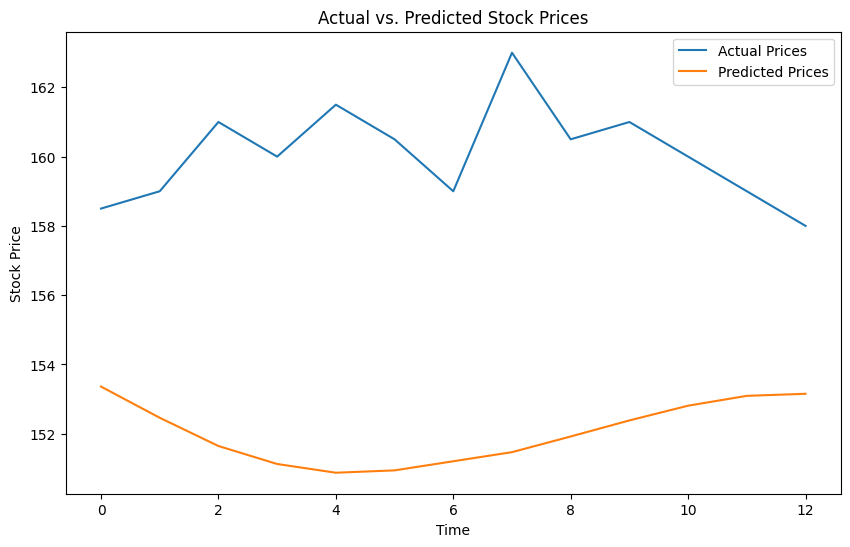

In [51]:
# Step 7: Evaluationg model

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, test_predictions)
print(f"Mean Squared Error: {mse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, test_predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [52]:
# Step 7: Evaluationg model

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test_rescaled, test_predictions)
print(f"R Squared Score: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
R Squared Score: -37.89189992290875
